In [1]:
import pandas as pd

# Load each dataset separately
train_df = pd.read_excel("cleaned_training_data_v3.xlsx")
test_df = pd.read_excel("cleaned_test_data_v3.xlsx")
real_df = pd.read_excel("cleaned_realuse_data_v3.xlsx")

def extract_concussion_data(df):
    # Only search in relevant injury/illness columns
    relevant_columns = [
        'Injury location', 
        'Injury type', 
        'Type of illness'  # Only include columns where concussion would logically appear
    ]
    
    # Create concussion mask - only check relevant columns
    concussion_mask = pd.Series(False, index=df.index)
    for col in relevant_columns:
        if col in df.columns:
            concussion_mask = concussion_mask | df[col].str.contains('concussion', case=False, na=False)
    
    # Get only true concussion cases
    concussion_cases = df[concussion_mask].copy()
    
    # Ensure we have datetime
    concussion_cases['Date'] = pd.to_datetime(concussion_cases['Date'])
    
    results = []
    
    for _, case in concussion_cases.iterrows():
        user_id = case['User ID']
        concussion_date = case['Date']
        
        # Get all records for this user
        user_records = df[df['User ID'] == user_id].copy()
        user_records['Date'] = pd.to_datetime(user_records['Date'])
        
        # Define time windows
        before_start = concussion_date - pd.DateOffset(months=1)
        after_end = concussion_date + pd.DateOffset(months=3)
        
        # Get records in time window
        before = user_records[
            (user_records['Date'] >= before_start) & 
            (user_records['Date'] < concussion_date)
        ]

        during = user_records[
            user_records['Date'] == concussion_date
        ].copy()
        
        after = user_records[
            (user_records['Date'] > concussion_date) & 
            (user_records['Date'] <= after_end)
        ]
        
        # Mark which records are before/after
        before['Time Period'] = 'Before Concussion'
        during['Time Period'] = 'Concussion Event Day'
        after['Time Period'] = 'After Concussion'
        
        # Add concussion info
        for df_part in [before, during, after]:
            df_part['Concussion Date'] = concussion_date
            df_part['Concussion Record'] = (df_part['Date'] == concussion_date)
        
        # Add to results
        results.extend([before, during, after])
    
    if results:
        return pd.concat(results)
    return pd.DataFrame()

# Process each dataset
train_concussion = extract_concussion_data(train_df)
test_concussion = extract_concussion_data(test_df)
real_concussion = extract_concussion_data(real_df)

# Combine all data
all_concussion_data = pd.concat([
    train_concussion,
    test_concussion,
    real_concussion
]).sort_values(['Year', 'User ID', 'Date'])

# Save to Excel
all_concussion_data.to_excel("accurate_concussion_analysis.xlsx", index=False)

print(f"Found {len(all_concussion_data)} records related to concussions.")

/var/folders/14/h9qhwyxs0qdgk3yp44lmycd40000gn/T/ipykernel_96168/2336491489.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  before['Time Period'] = 'Before Concussion'
/var/folders/14/h9qhwyxs0qdgk3yp44lmycd40000gn/T/ipykernel_96168/2336491489.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after['Time Period'] = 'After Concussion'
/var/folders/14/h9qhwyxs0qdgk3yp44lmycd40000gn/T/ipykernel_96168/2336491489.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

Found 3593 records related to concussions.


Training features for illness model: 21
Saving vectorizers...
Test features for illness model: 21
Real-use features for illness model: 21
Test features for injury model: (138640, 70)
Real-use features for injury model: (100107, 70)
Loading saved model from: saved_models/rf_model_illness.pkl
Loading saved model from: saved_models/rf_model_injury.pkl
Loading saved model from: saved_models/log_reg_model_illness.pkl
Loading saved model from: saved_models/log_reg_model_injury.pkl
Loading saved model from: saved_models/xgb_model_illness.pkl
Loading saved model from: saved_models/xgb_model_injury.pkl

================================================== handling xgb illness label encoder ==================================================
loading label encoder for xgb: saved_models/xgb_illness_label_encoder.pkl

================================================== handling xgb injury label encoder ==================================================
loading label encoder for xgb: saved_models/xgb_in

/Users/dingyangzuo/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dingyangzuo/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dingyangzuo/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                                            precision    recall  f1-score   support

                 Chest Infection, moderate       0.33      1.00      0.50         1
                   Chest Infection, severe       1.00      1.00      1.00         1
                         Common Cold, mild       1.00      1.00      1.00         5
                     Common Cold, moderate       0.73      1.00      0.84         8
                       Common Cold, severe       0.00      0.00      0.00         3
                       Diarrhoea, moderate       0.00      0.00      0.00         0
                          Diarrhoea, other       0.00      0.00      0.00         1
                   Eye Infection, moderate       0.00      0.00      0.00         2
                             Flu, moderate       0.20      1.00      0.33         2
                                Flu, other       0.00      0.00      0.00         2
                               Flu, severe       0.00      0.00      0.00  

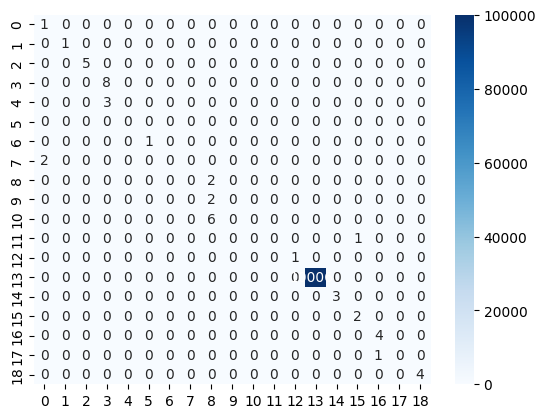

Logistic Regression Illness Prediction - Accuracy Score: 0.9998401710170118
Logistic Regression Illness Prediction - Classification Report:


/Users/dingyangzuo/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dingyangzuo/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dingyangzuo/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                                            precision    recall  f1-score   support

                 Chest Infection, moderate       0.33      1.00      0.50         1
                   Chest Infection, severe       1.00      1.00      1.00         1
                         Common Cold, mild       1.00      1.00      1.00         5
                     Common Cold, moderate       0.73      1.00      0.84         8
                       Common Cold, severe       0.00      0.00      0.00         3
                       Diarrhoea, moderate       0.00      0.00      0.00         0
                          Diarrhoea, other       0.00      0.00      0.00         1
                   Eye Infection, moderate       0.00      0.00      0.00         2
                             Flu, moderate       0.20      1.00      0.33         2
                                Flu, other       0.00      0.00      0.00         2
                               Flu, severe       0.00      0.00      0.00  

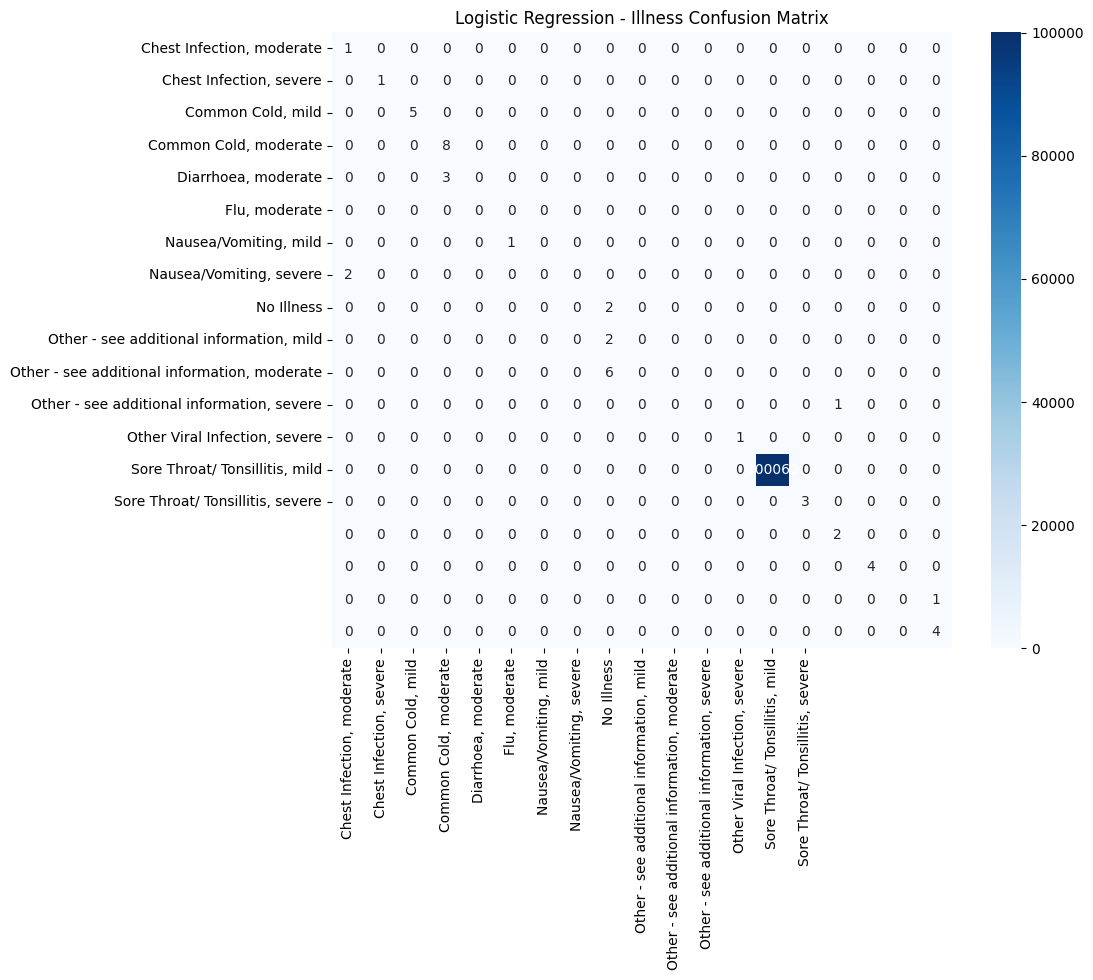

XGBoost Illness Prediction - Accuracy Score: 0.9998401710170118
XGBoost Illness Prediction - Classification Report:


/Users/dingyangzuo/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dingyangzuo/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dingyangzuo/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                                            precision    recall  f1-score   support

                 Chest Infection, moderate       1.00      1.00      1.00         1
                   Chest Infection, severe       0.33      1.00      0.50         1
                         Common Cold, mild       1.00      1.00      1.00         5
                     Common Cold, moderate       0.73      1.00      0.84         8
                       Common Cold, severe       0.00      0.00      0.00         3
                       Diarrhoea, moderate       0.00      0.00      0.00         0
                          Diarrhoea, other       0.00      0.00      0.00         1
                   Eye Infection, moderate       0.00      0.00      0.00         2
                             Flu, moderate       0.18      1.00      0.31         2
                                Flu, other       0.00      0.00      0.00         2
                               Flu, severe       0.00      0.00      0.00  

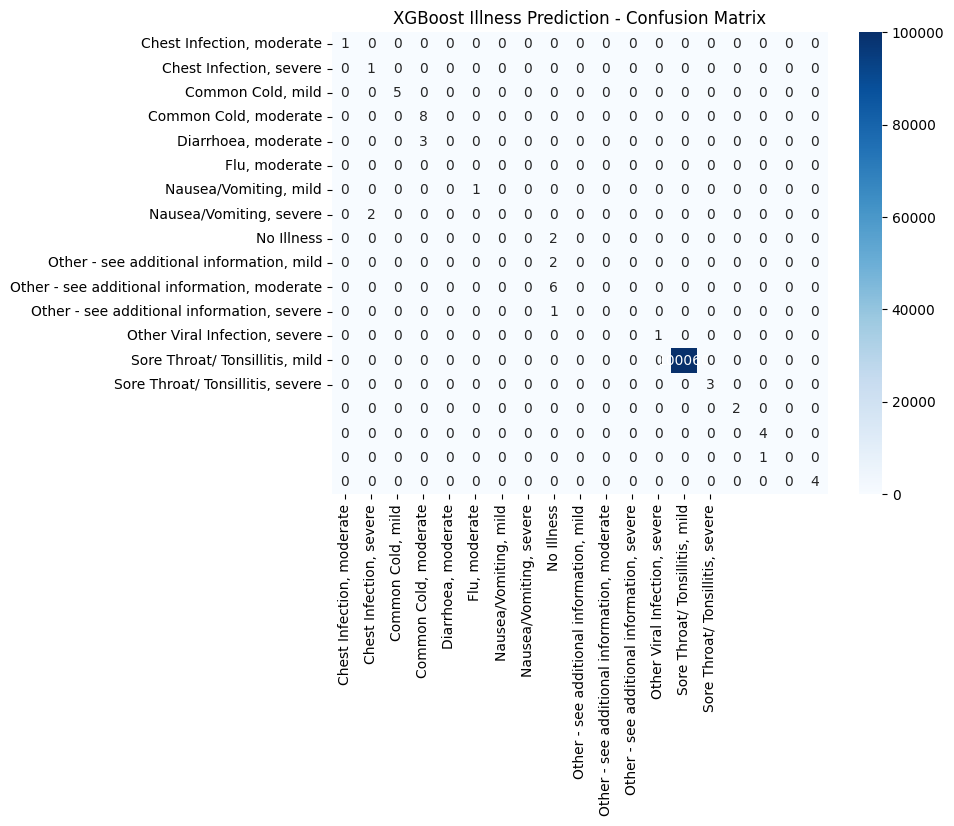

Random Forest Injury Prediction - Accuracy Score: 0.9993107375108634
Random Forest Injury Prediction - Classification Report:


/Users/dingyangzuo/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dingyangzuo/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dingyangzuo/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                                                                            precision    recall  f1-score   support

                          Ankle, Laceration, Grass, Firm, Muscle, moderate       0.00      0.00      0.00         1
                                   Ankle, Other, Other, Hard, Bone, severe       0.00      0.00      0.00         1
                         Ankle, Sprain, Concrete, Firm, Ligament, moderate       0.00      0.00      0.00         1
                                       Ankle, Sprain, Concrete, Firm, mild       0.00      0.00      0.00         1
                            Ankle, Sprain, Grass, Firm, Not Sure, moderate       0.00      0.00      0.00         0
                            Ankle, Sprain, Grass, Good, Not Sure, moderate       0.00      0.00      0.00         1
                                  Ankle, Sprain, Grass, Good, Tendon, mild       0.00      0.00      0.00         1
                            Ankle, Sprain, Grass, Soft, Not Sure, moder

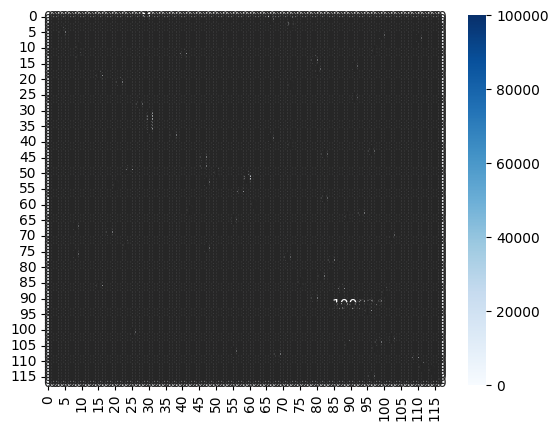

Logistic Regression Injury Prediction - Accuracy Score: 0.9993107375108634
Logistic Regression Injury Prediction - Classification Report:


/Users/dingyangzuo/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dingyangzuo/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dingyangzuo/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                                                                             precision    recall  f1-score   support

                           Ankle, Laceration, Grass, Firm, Muscle, moderate       0.00      0.00      0.00         1
                   Ankle, Laceration, Other, Slippery/Wet, Muscle, moderate       0.00      0.00      0.00         0
                                      Ankle, Other, Grass, Good, Bone, mild       0.00      0.00      0.00         0
                                    Ankle, Other, Other, Hard, Bone, severe       0.00      0.00      0.00         1
                          Ankle, Sprain, Concrete, Firm, Ligament, moderate       0.00      0.00      0.00         1
                            Ankle, Sprain, Concrete, Firm, Not Sure, severe       0.00      0.00      0.00         0
                                        Ankle, Sprain, Concrete, Firm, mild       0.00      0.00      0.00         1
                                 Ankle, Sprain, Grass, Good, No

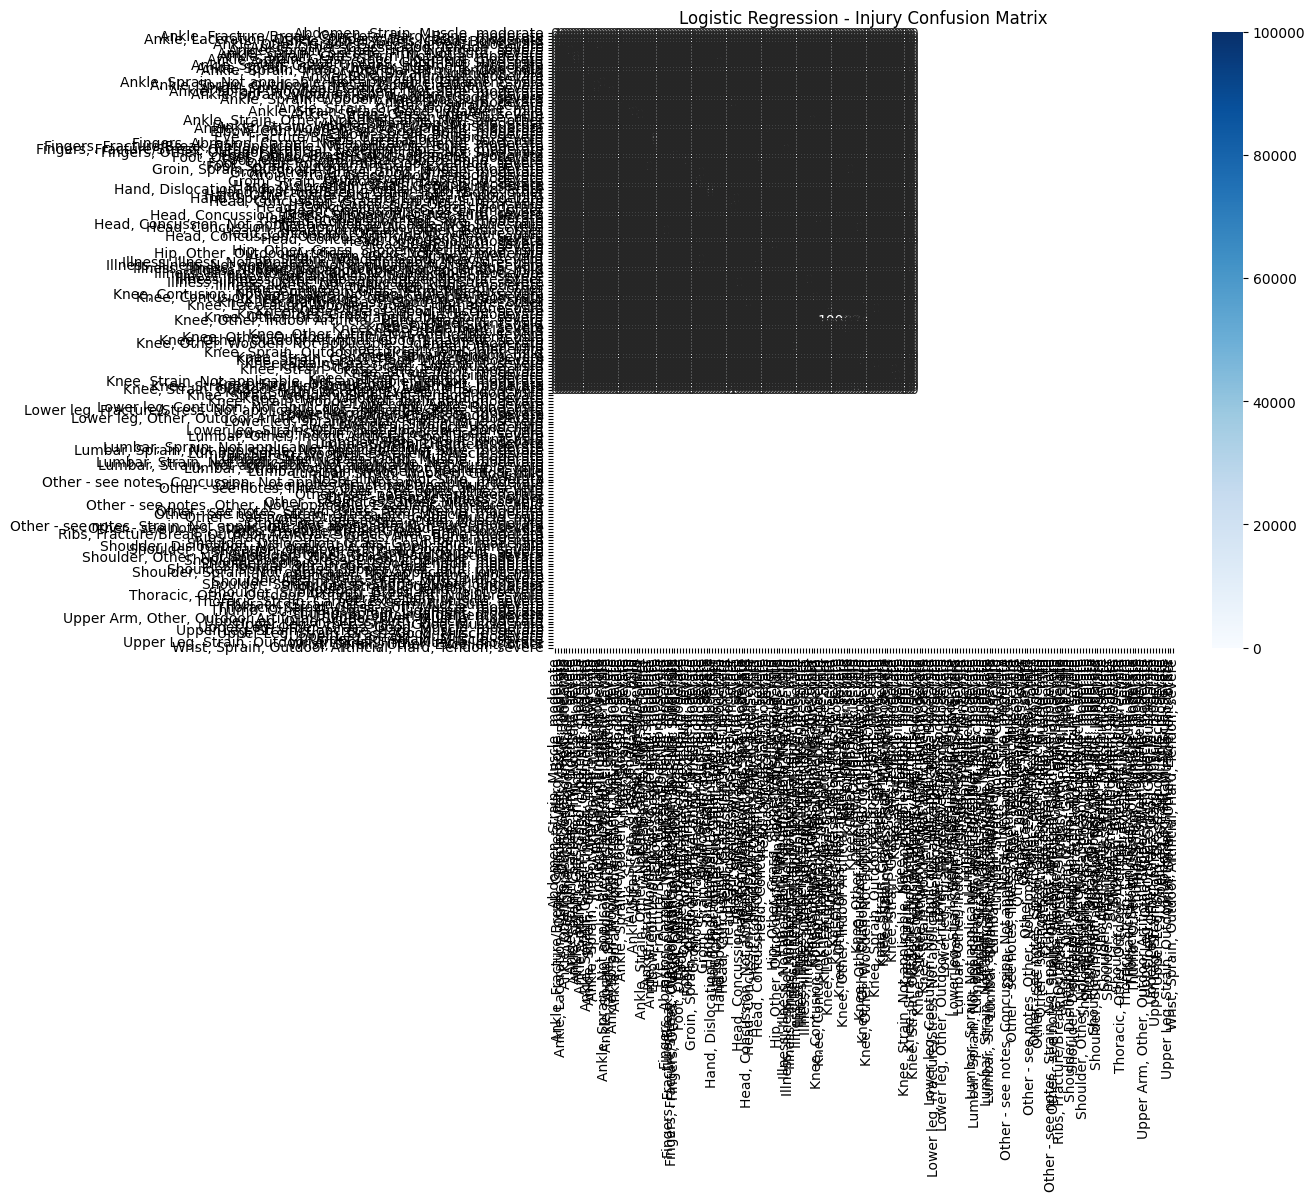

XGBoost Injury Prediction - Accuracy Score: 0.9993107375108634
XGBoost Injury Prediction - Classification Report:


/Users/dingyangzuo/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dingyangzuo/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dingyangzuo/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                                                                       precision    recall  f1-score   support

                     Ankle, Laceration, Grass, Firm, Muscle, moderate       0.00      0.00      0.00         1
                                Ankle, Other, Grass, Good, Bone, mild       0.00      0.00      0.00         0
                              Ankle, Other, Other, Hard, Bone, severe       0.00      0.00      0.00         1
                    Ankle, Sprain, Concrete, Firm, Ligament, moderate       0.00      0.00      0.00         1
                                  Ankle, Sprain, Concrete, Firm, mild       0.00      0.00      0.00         1
                       Ankle, Sprain, Grass, Firm, Not Sure, moderate       0.00      0.00      0.00         0
                       Ankle, Sprain, Grass, Good, Ligament, moderate       0.00      0.00      0.00         0
                       Ankle, Sprain, Grass, Good, Not Sure, moderate       0.00      0.00      0.00         1


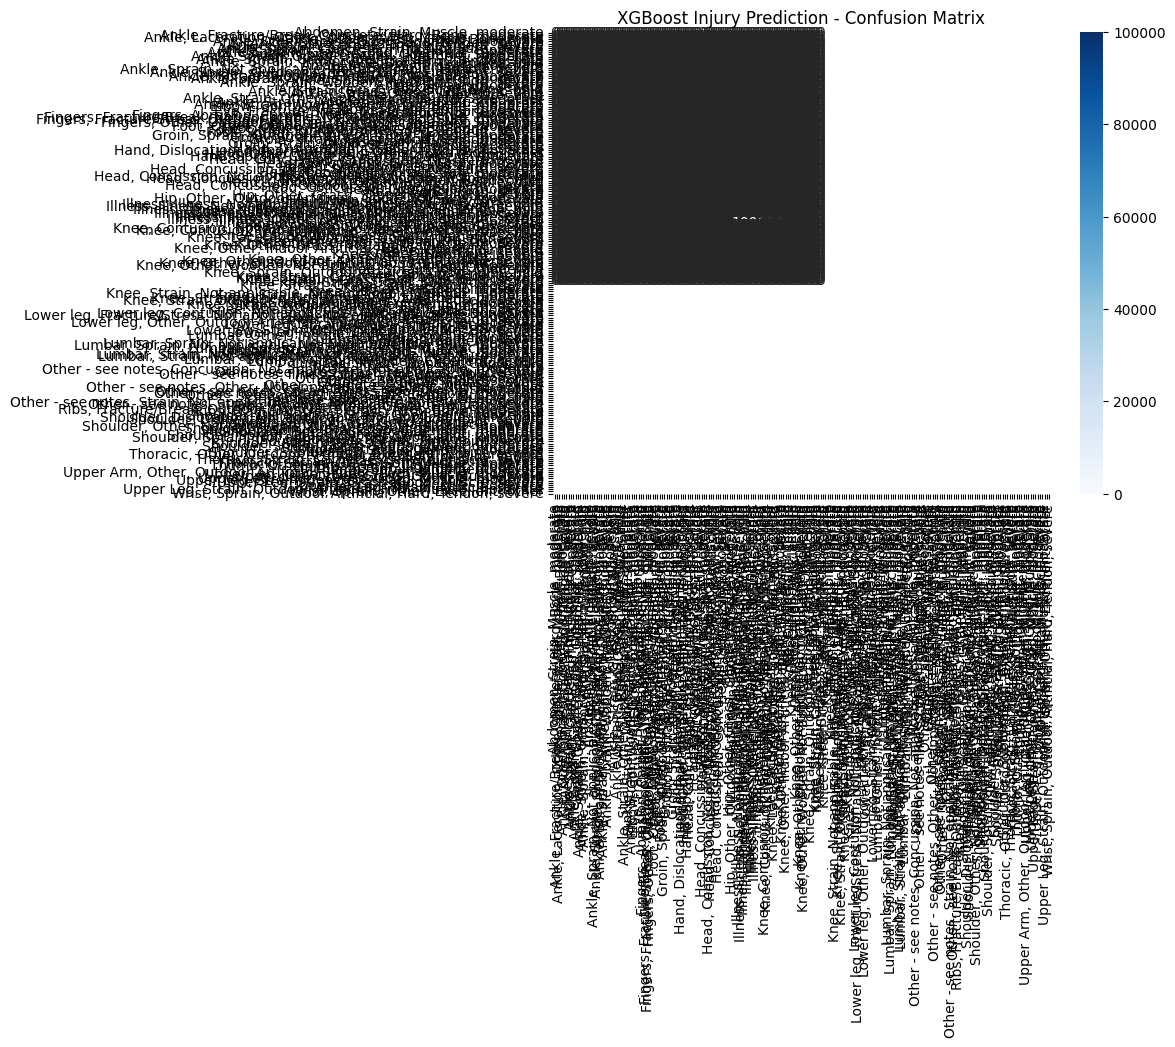

Improved prediction results saved to improved_predictions_results.xlsx


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import xgboost as xgb
import matplotlib.pyplot as plt
import openpyxl
from openpyxl.styles import PatternFill
from openpyxl.drawing.image import Image
from openpyxl import Workbook
import os
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# -----------------------------------------------------------------------------------------------------------------------------------------
## Step 4-1:  Model Initializing for Injury/Illness Details Prediction

# directory to save models
model_dir = 'saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
# set GPU acceleration
def setup_gpu_acceleration():
    try:
        from xgboost import XGBClassifier
        return XGBClassifier(tree_method='hist', device='cpu')
    except ImportError:
        print("Metal acceleration not available. Falling back to CPU.")
        return XGBClassifier(tree_method='hist', device='cpu')

# set checkpoints
def train_model_with_checkpoints(model, X_train, y_train, model_path, checkpoint_interval=1, max_rounds=20):
    checkpoint_path = os.path.join(model_dir, 'xgb_injury_model_checkpoint.pkl') 
    checkpoint_file = os.path.join(model_dir, 'xgb_injury_model_checkpoint_rounds.txt')
    start_iteration = 0

    # check if there's an existing model or checkpoint to resume from
    if os.path.exists(model_path):
        print(f"Loading saved model from: {model_path}")
        model = joblib.load(model_path)
        if hasattr(model, 'best_iteration'):
            start_iteration = model.best_iteration
    elif os.path.exists(checkpoint_path):
        print(f"Resuming training from checkpoint: {checkpoint_path}")
        model = joblib.load(checkpoint_path)
        if hasattr(model, 'best_iteration'):
            start_iteration = model.best_iteration

        if os.path.exists(checkpoint_file):
            with open(checkpoint_file, 'r') as f:
                checkpoint_rounds = int(f.read().strip())
                print(f"Resuming from saved round: {checkpoint_rounds}")
                start_iteration = checkpoint_rounds

            if checkpoint_rounds is not None:
                start_iteration = checkpoint_rounds

    # training the model
    eval_set = [(X_train, y_train)]

    # if continuing from an existing model or checkpoint, resume training
    for i in range(start_iteration, max_rounds):
        model.fit(X_train, y_train, eval_set=eval_set, verbose=True, xgb_model=model.get_booster() if i > 0 else None)
        
        # save checkpoint after each round
        print(f"Saving model after iteration {i+1}")
        joblib.dump(model, checkpoint_path)  # save the model checkpoint
        
        # save the round checkpoint number
        with open(checkpoint_file, 'w') as f:
            f.write(str(i + 1))

    # save the final model
    joblib.dump(model, model_path)

    # clean up the checkpoint file after final save
    if os.path.exists(checkpoint_path):
        os.remove(checkpoint_path)

    return model

# load training and testing data
train_df = pd.read_excel("cleaned_training_data_v3.xlsx")
test_df = pd.read_excel("cleaned_test_data_v3.xlsx")
realuse_df = pd.read_excel("cleaned_realuse_data_v3.xlsx")

# preprocessing the numeric features
numeric_features = ['Gender_m2f1', 'Menstruation_y1n0', 'Mood state', 'Energy levels',
                    'Muscle readiness', 'Academic Pressure', 'Diet Yesterday', 'Sleep quality',
                    'Sleep duration', 'sleep_score', 'total_training_load', 'total_training_duration',
                    'weekly_training_load', 'weekly_training_duration', 'ACWR', 'RTT', 'illed', 'injured']

# separate numeric features from the rest
X_train = train_df[numeric_features]
X_test = test_df[numeric_features]
X_real = realuse_df[numeric_features]

# preprocessing the text data

# combine text columns for illness and injury separately
illness_columns = ['Type of illness', 'Illness severity']
injury_columns = ['Injury location', 'Injury type', 'Injury surface', 'Surface condition', 'Injury tissue type', 'Injury severity']

# fill missing values with empty strings and concatenate the text columns
train_df['illness_text'] = train_df[illness_columns].fillna('').agg(' '.join, axis=1)
train_df['injury_text'] = train_df[injury_columns].fillna('').agg(' '.join, axis=1)
test_df['illness_text'] = test_df[illness_columns].fillna('').agg(' '.join, axis=1)
test_df['injury_text'] = test_df[injury_columns].fillna('').agg(' '.join, axis=1)
realuse_df['illness_text'] = realuse_df[illness_columns].fillna('').agg(' '.join, axis=1)
realuse_df['injury_text'] = realuse_df[injury_columns].fillna('').agg(' '.join, axis=1)
train_df['injury_information'] = train_df['injury_information'].fillna("No Injury")
train_df['illness_information'] = train_df['illness_information'].fillna("No Illness")
test_df['injury_information'] = test_df['injury_information'].fillna("No Injury")
test_df['illness_information'] = test_df['illness_information'].fillna("No Illness")
realuse_df['injury_information'] = realuse_df['injury_information'].fillna("No Injury")
realuse_df['illness_information'] = realuse_df['illness_information'].fillna("No Illness")

# vectorize the text data using TfidfVectorizer
tfidf_vectorizer_illness = TfidfVectorizer(max_features=500)
tfidf_vectorizer_injury = TfidfVectorizer(max_features=500)

# fit on training data, then transform test and real use data
X_illness_train = tfidf_vectorizer_illness.fit_transform(train_df['illness_information'])
X_injury_train = tfidf_vectorizer_injury.fit_transform(train_df['injury_information'])
# check feature dimensions
print("Training features for illness model:", X_illness_train.shape[1])

# save the vectorizers
print("Saving vectorizers...")
joblib.dump(tfidf_vectorizer_illness, os.path.join(model_dir, 'tfidf_vectorizer_illness.pkl'))
joblib.dump(tfidf_vectorizer_injury, os.path.join(model_dir, 'tfidf_vectorizer_injury.pkl'))

X_illness_test = tfidf_vectorizer_illness.transform(test_df['illness_information'])
X_injury_test = tfidf_vectorizer_injury.transform(test_df['injury_information'])
X_illness_real = tfidf_vectorizer_illness.transform(realuse_df['illness_information'])
X_injury_real = tfidf_vectorizer_injury.transform(realuse_df['injury_information'])
# check feature dimensions for test and real-use data
print("Test features for illness model:", X_illness_test.shape[1])
print("Real-use features for illness model:", X_illness_real.shape[1])
print("Test features for injury model:",X_injury_train.shape)
print("Real-use features for injury model:",X_injury_test.shape)

# create an instance of RandomOverSampler
ros = RandomOverSampler(random_state=42)

# resample the training data based on illness and injury (use RandomOverSampler instead of SMOTE)
X_resampled_illness, y_resampled_illness = ros.fit_resample(X_illness_train, train_df['illness_information'])
X_resampled_injury, y_resampled_injury = ros.fit_resample(X_injury_train, train_df['injury_information'])

X_train_illness, X_test_illness, y_train_illness, y_test_illness = train_test_split(X_resampled_illness, y_resampled_illness, test_size=0.2, random_state=42)
X_train_injury, X_test_injury, y_train_injury, y_test_injury = train_test_split(X_resampled_injury, y_resampled_injury, test_size=0.2, random_state=42)
# -----------------------------------------------------------------------------------------------------------------------------------------
## Step 4-2: Model Selection, Hyperparameters Fine Tuning, Training

# model file paths
rf_illness_model_path = os.path.join(model_dir, 'rf_model_illness.pkl')
rf_injury_model_path = os.path.join(model_dir, 'rf_model_injury.pkl')
log_reg_illness_model_path = os.path.join(model_dir, 'log_reg_model_illness.pkl')
log_reg_injury_model_path = os.path.join(model_dir, 'log_reg_model_injury.pkl')
xgb_illness_model_path = os.path.join(model_dir, 'xgb_model_illness.pkl')
xgb_injury_model_path = os.path.join(model_dir, 'xgb_model_injury.pkl')
xgb_illness_label_encoder_path = os.path.join(model_dir, 'xgb_illness_label_encoder.pkl')
xgb_injury_label_encoder_path = os.path.join(model_dir, 'xgb_injury_label_encoder.pkl')
log_reg_illness_model_path = os.path.join(model_dir, 'log_reg_model_illness.pkl')
log_reg_illness_label_encoder_path = os.path.join(model_dir, 'label_encoder_log_reg_illness.pkl')

# check if models are saved, and load them if available
def load_model(model_path):
    if os.path.exists(model_path):
        print(f"Loading saved model from: {model_path}")
        return joblib.load(model_path)
    return None

# load existing models or train if they exist
best_rf_model_illness = load_model(rf_illness_model_path)
best_rf_model_injury = load_model(rf_injury_model_path)
best_log_reg_model_illness = load_model(log_reg_illness_model_path)
best_log_reg_model_injury = load_model(log_reg_injury_model_path)
best_xgb_model_illness = load_model(xgb_illness_model_path)
best_xgb_model_injury = load_model(xgb_injury_model_path)

# if no model is loaded, perform hyperparameter tuning and training
if best_rf_model_illness is None:
    # randomForest for illness prediction with predefined hyperparameters
    rf_param_illness = {
        'n_estimators': 200,
        'max_depth': 20,
        'min_samples_split': 5,
        'min_samples_leaf': 2,
        'max_features': 'sqrt',
        'class_weight': 'balanced'
    }
    best_rf_model_illness = RandomForestClassifier(random_state=42, **rf_param_illness)
    best_rf_model_illness.fit(X_train_illness, y_train_illness)
    joblib.dump(best_rf_model_illness, rf_illness_model_path)

if best_rf_model_injury is None:
    # randomForest for injury prediction with predefined hyperparameters
    rf_param_injury = {
        'n_estimators': 200,
        'max_depth': 20,
        'min_samples_split': 5,
        'min_samples_leaf': 2,
        'max_features': 'sqrt',
        'class_weight': 'balanced'
    }
    best_rf_model_injury = RandomForestClassifier(random_state=42, **rf_param_injury)
    best_rf_model_injury.fit(X_train_injury, y_train_injury)
    joblib.dump(best_rf_model_injury, rf_injury_model_path)

if best_log_reg_model_illness is None:
    # encode the string labels to numeric labels
    label_encoder_illness = LabelEncoder()
    y_train_illness_encoded = label_encoder_illness.fit_transform(y_train_illness)
    joblib.dump(label_encoder_illness, 'label_encoder_log_reg_illness.pkl')
    # get unique classes in the encoded labels
    unique_classes_illness = np.unique(y_train_illness_encoded)
    # calculate class weights
    class_weights_illness = compute_class_weight('balanced', classes=unique_classes_illness, y=y_train_illness_encoded)
    class_weight_dict_illness = dict(zip(unique_classes_illness, class_weights_illness))
    log_reg_param_illness = {
        'C': 1,
        'penalty': 'l2',
        'solver': 'liblinear',
        'class_weight': class_weight_dict_illness
    }
    best_log_reg_model_illness = LogisticRegression(random_state=42, max_iter=1000, **log_reg_param_illness)
    best_log_reg_model_illness.fit(X_train_illness, y_train_illness_encoded)
    joblib.dump(best_log_reg_model_illness, log_reg_illness_model_path)


if best_log_reg_model_injury is None:
    # encode the string labels to numeric labels
    label_encoder_injury = LabelEncoder()
    y_train_injury_encoded = label_encoder_injury.fit_transform(y_train_injury)
    joblib.dump(label_encoder_injury, 'label_encoder_log_reg_injury.pkl')
    # get unique classes in the encoded labels
    unique_classes_injury = np.unique(y_train_injury_encoded)
    # calculate class weights
    class_weights_injury = compute_class_weight('balanced', classes=unique_classes_injury, y=y_train_injury_encoded)
    class_weight_dict_injury = dict(zip(unique_classes_injury, class_weights_injury))
    log_reg_param_injury = {
        'C': 1,
        'penalty': 'l2',
        'solver': 'liblinear',
        'class_weight': class_weight_dict_injury
    }
    best_log_reg_model_injury = LogisticRegression(random_state=42, max_iter=1000, **log_reg_param_injury)
    best_log_reg_model_injury.fit(X_train_injury, y_train_injury_encoded)
    joblib.dump(best_log_reg_model_injury, log_reg_injury_model_path)

# function to encode the target variable
def handle_label_encoder(y_train, encoder_path):
    if os.path.exists(encoder_path):
        print(f"loading label encoder for xgb: {encoder_path}")
        encoder = joblib.load(encoder_path)
        y_encoded = encoder.transform(y_train) 
    else:
        print(f"creating new label encoder for xgb: {encoder_path}")
        encoder = LabelEncoder()
        y_encoded = encoder.fit_transform(y_train)
        joblib.dump(encoder, encoder_path)
    return y_encoded, encoder

print("\n" + "="*50 + " handling xgb illness label encoder " + "="*50)
y_train_illness_encoded, illness_encoder = handle_label_encoder(y_train_illness, xgb_illness_label_encoder_path)

print("\n" + "="*50 + " handling xgb injury label encoder " + "="*50)
y_train_injury_encoded, injury_encoder = handle_label_encoder(y_train_injury, xgb_injury_label_encoder_path)

if best_xgb_model_illness is None:
    # XGBoost for illness prediction with GPU acceleration
    positive_class_count_illness = sum(y_train_illness_encoded == 1)
    negative_class_count_illness = sum(y_train_illness_encoded == 0)

    if positive_class_count_illness > 0:
        scale_pos_weight_illness = negative_class_count_illness / positive_class_count_illness
        xgb_param_illness = {
            'n_estimators': 20,
            'learning_rate': 0.1,
            'max_depth': 5,
            'subsample': 0.9,
            'colsample_bytree': 0.8,
            'enable_categorical':True,
            'tree_method': 'hist', 
            'device': 'cpu',
            'eval_metric': 'mlogloss',
            'early_stopping_rounds': 10,
            'scale_pos_weight': scale_pos_weight_illness
        }
    else:
        xgb_param_illness = {
            'n_estimators': 20,
            'learning_rate': 0.1,
            'max_depth': 5,
            'subsample': 0.9,
            'colsample_bytree': 0.8,
            'enable_categorical':True,
            'tree_method': 'hist',  
            'device': 'cpu',  
            'eval_metric': 'mlogloss',
            'early_stopping_rounds': 10
        }
    best_xgb_model_illness = xgb.XGBClassifier(random_state=42, **xgb_param_illness)
    best_xgb_model_illness = train_model_with_checkpoints(
        model=best_xgb_model_illness,
        X_train=X_train_illness,
        y_train=y_train_illness_encoded,
        model_path=xgb_illness_model_path,
        checkpoint_interval=1,
        max_rounds=20
    )

if best_xgb_model_injury is None:
    # XGBoost for injury prediction with predefined hyperparameters
    positive_class_count_injury = sum(y_train_injury == 1)
    negative_class_count_injury = sum(y_train_injury == 0)
    if positive_class_count_injury > 0:
        scale_pos_weight_injury = negative_class_count_injury / positive_class_count_injury
        xgb_param_injury = {
            'n_estimators': 1,
            'learning_rate': 0.1,
            'max_depth': 5,
            'subsample': 0.9,
            'colsample_bytree': 0.8,
            'enable_categorical':True,
            'tree_method': 'hist',  
            'device': 'cpu',  
            'eval_metric': 'mlogloss',
            'early_stopping_rounds': 3,
            'scale_pos_weight': scale_pos_weight_injury
        }
    else:
        xgb_param_injury = {
            'n_estimators': 1,
            'learning_rate': 0.1,
            'max_depth': 5,
            'subsample': 0.9,
            'colsample_bytree': 0.8,
            'enable_categorical':True,
            'tree_method': 'hist',  
            'device': 'cpu',  
            'eval_metric': 'mlogloss',
            'early_stopping_rounds': 3
        }
    best_xgb_model_injury = xgb.XGBClassifier(random_state=42, **xgb_param_injury)
    best_xgb_model_injury = train_model_with_checkpoints(
        model=best_xgb_model_injury,
        X_train=X_train_injury,
        y_train=y_train_injury_encoded,
        model_path=xgb_injury_model_path,
        checkpoint_interval=1,
        max_rounds=1
    )

# after GridSearchCV, we can use the best models for prediction:
y_pred_illness_rf_test = best_rf_model_illness.predict(X_illness_test)
y_pred_injury_rf_test = best_rf_model_injury.predict(X_injury_test)

log_reg_label_encoder_illness = joblib.load('label_encoder_log_reg_illness.pkl')
y_pred_illness_lr_test = best_log_reg_model_illness.predict(X_illness_test)
y_pred_illness_lr_test_labels = log_reg_label_encoder_illness.inverse_transform(y_pred_illness_lr_test)
log_reg_label_encoder_injury = joblib.load('label_encoder_log_reg_injury.pkl')
y_pred_injury_lr_test = best_log_reg_model_injury.predict(X_injury_test)
y_pred_injury_lr_test_labels = log_reg_label_encoder_injury.inverse_transform(y_pred_injury_lr_test)

y_pred_illness_xgb_test = best_xgb_model_illness.predict(X_illness_test)
y_pred_injury_xgb_test = best_xgb_model_injury.predict(X_injury_test)

# -----------------------------------------------------------------------------------------------------------------------------------------
# model evaluation for all illness prediction
print("Random Forest Illness Prediction - Accuracy Score:", accuracy_score(test_df['illness_information'], y_pred_illness_rf_test))
print("Random Forest Illness Prediction - Classification Report:")
print(classification_report(test_df['illness_information'], y_pred_illness_rf_test))
print("Random Forest Illness Prediction - Confusion Matrix:")
cm_illness_rf_test = confusion_matrix(test_df['illness_information'], y_pred_illness_rf_test)
sns.heatmap(cm_illness_rf_test, annot=True, fmt="d", cmap="Blues")
plt.show()

print("Logistic Regression Illness Prediction - Accuracy Score:", accuracy_score(test_df['illness_information'], y_pred_illness_lr_test_labels))
print("Logistic Regression Illness Prediction - Classification Report:")
print(classification_report(test_df['illness_information'], y_pred_illness_lr_test_labels))
print("Logistic Regression Illness Prediction - Confusion Matrix:")
plt.figure(figsize=(10, 8))
cm_illness_lr_test = confusion_matrix(test_df['illness_information'], y_pred_illness_lr_test_labels)
# load the logistic regression label encoder for illness
lr_label_encoder_illness = joblib.load('label_encoder_log_reg_illness.pkl')
sns.heatmap(cm_illness_lr_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=lr_label_encoder_illness.classes_,
            yticklabels=lr_label_encoder_illness.classes_)
plt.title("Logistic Regression - Illness Confusion Matrix")
plt.show()

# load label encoders for evaluation
label_encoder_illness = joblib.load(xgb_illness_label_encoder_path)
# convert predictions back to original labels
y_pred_illness_xgb_test_labels = label_encoder_illness.inverse_transform(y_pred_illness_xgb_test)
print("XGBoost Illness Prediction - Accuracy Score:", accuracy_score(test_df['illness_information'], y_pred_illness_xgb_test_labels))
print("XGBoost Illness Prediction - Classification Report:")
print(classification_report(test_df['illness_information'], y_pred_illness_xgb_test_labels))
print("XGBoost Illness Prediction - Confusion Matrix:")
cm_illness_xgb_test = confusion_matrix(test_df['illness_information'], y_pred_illness_xgb_test_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_illness_xgb_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder_illness.classes_,
            yticklabels=label_encoder_illness.classes_)
plt.title("XGBoost Illness Prediction - Confusion Matrix")
plt.show()

# model evaluation for all injury prediction
print("Random Forest Injury Prediction - Accuracy Score:", accuracy_score(test_df['injury_information'], y_pred_injury_rf_test))
print("Random Forest Injury Prediction - Classification Report:")
print(classification_report(test_df['injury_information'], y_pred_injury_rf_test))
print("Random Forest Injury Prediction - Confusion Matrix:")
cm_injury_rf_test = confusion_matrix(test_df['injury_information'], y_pred_injury_rf_test)
sns.heatmap(cm_injury_rf_test, annot=True, fmt="d", cmap="Blues")
plt.show()

print("Logistic Regression Injury Prediction - Accuracy Score:", accuracy_score(test_df['injury_information'], y_pred_injury_lr_test_labels))
print("Logistic Regression Injury Prediction - Classification Report:")
print(classification_report(test_df['injury_information'], y_pred_injury_lr_test_labels))
print("Logistic Regression Injury Prediction - Confusion Matrix:")
plt.figure(figsize=(10, 8))
cm_injury_lr_test = confusion_matrix(test_df['injury_information'], y_pred_injury_lr_test_labels)
# load the logistic regression label encoder for injury
lr_label_encoder_injury = joblib.load('label_encoder_log_reg_injury.pkl')
sns.heatmap(cm_injury_lr_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=lr_label_encoder_injury.classes_,
            yticklabels=lr_label_encoder_injury.classes_)
plt.title("Logistic Regression - Injury Confusion Matrix")
plt.show()

# load label encoders for evaluation
label_encoder_injury = joblib.load(xgb_injury_label_encoder_path)
# convert predictions back to original labels
y_pred_injury_xgb_test_labels = label_encoder_injury.inverse_transform(y_pred_injury_xgb_test)
print("XGBoost Injury Prediction - Accuracy Score:", accuracy_score(test_df['injury_information'], y_pred_injury_xgb_test_labels))
print("XGBoost Injury Prediction - Classification Report:")
print(classification_report(test_df['injury_information'], y_pred_injury_xgb_test_labels))
print("XGBoost Injury Prediction - Confusion Matrix:")
cm_injury_xgb_test = confusion_matrix(test_df['injury_information'], y_pred_injury_xgb_test_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_injury_xgb_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder_injury.classes_,
            yticklabels=label_encoder_injury.classes_)
plt.title("XGBoost Injury Prediction - Confusion Matrix")
plt.show()
